# Part 3: The OpenMC C-API

Welcome to the third part of the OpenMC workshop. This section will show the basics of using OpenMC's C-API for performing multiphysics coupling. OpenMC's C-API allows you to interact with an OpenMC simulation in-memory by changing cell temperatures and densities, adding/removing tallies, and much more - all without re-initializing OpenMC between multiphysics feedback steps.

<span style="color:red">HINTS:</span>
* To run the commands, click on the relevant cell and hit the `shift + enter` keys simultaneously

Debugging tips
* Did you run all of the cells above your current cell? Try `Run -> Run All Above Selected Cell` from the menu
* Has the cell accidentally been switched from a `Code` cell to a `Raw` or `Markdown` cell? Check the dropdown menu that is to the far right of the save button
* If all else fails, switch over to the filled-in .ipynb file.

# Problem Description

This example will couple OpenMC to a basic thermal-fluids solver for a UO2 pincell in water. 

![](setup.png)

OpenMC will send a volumetric heat source to the thermal-fluids solver, which will use this heat source to compute temperatures and densities that will be sent back to OpenMC. The two physics (OpenMC, thermal-fluids) will then be iterated several times in-memory.

We will divide the problem into $N$ axial cells in both OpenMC and the T/H app, with coupling between layer $i$ in OpenMC and layer $i$ in the T/H app. We will not couple solid _density_ to this problem because to properly conserve the fissile mass, this would require re-generation of the geometry (i.e. larger or smaller pin radii) with each coupled physics iteration.

To keep our main focus on OpenMC, all of the T/H physics is located in a separate Python module, `part3_backend`. This module contains functions that compute the fluid temperature, fluid density, and solid temperature based on steady state energy conservation. If you are interested in the models used for the thermal physics, please peruse this backend after the workshop!




In [1]:
# import all of the modules we will need
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import sys

import openmc
import openmc.lib

# import the T/H physics
import part3_backend

AttributeError: dlsym(0x7fb52b4cc810, openmc_rectilinear_mesh_get_grid): symbol not found

## Set up Thermal-Fluids Solver

Next, define the material properties and boundary conditions related to the thermal-hydraulic solver.
These values shown here roughly correspond to Pressurized Water Reactor (PWR) conditions.

In [2]:
R = 0.97 / 2.0           # outer radius of the pincell (cm)
Rf = 0.825 / 2.0         # outer radius of the pellet (cm)
pitch = 1.28             # pitch between pincells (cm)
height = 381.0           # height of the pincell (cm)

power = 60.0e3           # total power produced by pincell (W)
T_inlet = 573.0          # inlet water temperature (K)

Next, specify the number of layers we want to build in our model. Note that the more layers you add, the more particles you will need to see acceptable tally statistics in each layer!

In [4]:
N = 10                    # number of coupling layers         
H = height / N            # height of each coupling layer

NameError: name 'height' is not defined

# Materials

Now, let's define the materials we need for the pincell problem.

In OpenMC, a cell temperature can be changed without any underlying changes to the material that _fills_ that cell. For the solid regions where we are changing temperatures, but not densities, we only need a single material to represent the UO$_2$ and zircaloy.

In [9]:
# To save us some typing, we will create all the duplicated coolant materials
# in a loop, so first make a list to which we can append all of our materials
all_materials = []

# Then, add the materials for UO2 and zircaloy
uo2 = openmc.Material(name = 'UO2')
uo2.set_density('g/cm3', 10.29769)
uo2.add_element('U', 1.0, enrichment = 2.5)
uo2.add_element('O', 2.0)
all_materials.append(uo2)

zircaloy = openmc.Material(material_id=3, name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014, 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001, 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')
all_materials.append(zircaloy)

However, OpenMC treats density as tied to a particular material, so if we want to set $N$ different densities in the fluid, we need to create $N$ different fluid materials (even if _physically_, the coolant is water everywhere in the core).

In [11]:
water_materials = []

for i in range(N):
  water = openmc.Material(name = 'water{:n}'.format(i))
  water.set_density('g/cm3', part3_backend.water_density(T_inlet))
  water.add_element('H', 2.0)
  water.add_element('O', 1.0)
  water.add_s_alpha_beta('c_H_in_H2O')

  water_materials.append(water)
  all_materials.append(water)

Now, we simply need to register all of these materials in OpenMC and export them to XML for the C++ driver.

In [ ]:
materials = openmc.Materials(all_materials)
materials.export_to_xml()

# Geometry

Next, let's define the geometry, starting with the surfaces. Recall that because we are coupling temperatures and densities in $N$ layers, we will need to set up surfaces that bound each of these planes so that we can create separate cells for each coupling layer. So, after setting up the surfaces bounding the pincell surface, the pellet surface, and the rectangular prism forming the outer boundary, add one surface for each plane.

In [15]:
pincell_surface = openmc.ZCylinder(r = R, name = 'Pincell outer radius')
pellet_surface = openmc.ZCylinder(r = Rf, name = 'Pellet outer radius')
rectangular_prism = openmc.model.rectangular_prism(width = pitch, height = pitch, axis = 'z', origin = (0.0, 0.0), boundary_type = 'reflective')

# loop over all the surfaces needed to define the pincell (N + 1 for the N layers)
planes = np.linspace(0.0, height, N + 1)

plane_surfaces = []
for i in range(N + 1):
  plane_surfaces.append(openmc.ZPlane(z0 = planes[i]))

If not specified, OpenMC assumes that the boundary condition on all surfaces is reflective. For our example, we would instead like vacuum boundaries on the topmost and bottommost surfaces.

In [16]:
plane_surfaces[0].boundary_type = 'vacuum'
plane_surfaces[-1].boundary_type = 'vacuum'

Now that we have set up all the surfaces in our problem, we can add cells. Because we coupling on $N$ layers, we'll form these cells in a loop.

In [17]:
fuel_cells = []
clad_cells = []
water_cells = []

for i in range(N):
  # these are the two planes that bound the current layer on top and bottom
  layer = +plane_surfaces[i] & -plane_surfaces[i + 1]

  fuel_cells.append(openmc.Cell(fill = uo2, region = -pellet_surface & layer, name = 'Fuel{:n}'.format(i)))
    
  clad_cells.append(openmc.Cell(fill = zircaloy, region = +pellet_surface & -pincell_surface & layer, name = 'Clad{:n}'.format(i)))
  
  # we need to get the correct water material that belongs to this layer
  water_material = water_materials[i]
  water_cells.append(openmc.Cell(fill = water, region = +pincell_surface & layer & rectangular_prism, name = 'Water{:n}'.format(i)))

Now, we simply need to add all these cells to the root Universe for the problem and export to XML for the C++ driver.

In [18]:
root = openmc.Universe(name = 'root')
root.add_cells(fuel_cells)
root.add_cells(clad_cells)
root.add_cells(water_cells)

geometry = openmc.Geometry(root)
geometry.export_to_xml()

## Tallies

In order to provide a power to our T/H app, we need to extract the fission power from OpenMC. We therefore need to add tallies for the recoverable fission energy that is deposited in each layer. 

In addition, while our thermal-fluids solver requires input of a heat source in units of Watts, OpenMC's recoverable fission energy release tally, denoted by the score `kappa-fission`, are eV per source particle. In order to convert between these units and the Watts expected by the thermal-fluids solver, we will normalize according to:

$q_i=\frac{\kappa_i}{\kappa_\text{total}}P$

where $\kappa_i$ is the kappa-fission tally in layer $i$, $\kappa_\text{total}$ is a kappa-fission tally over the entire domain, $P$ is a specified power, and $q_i$ is the heat source (Watts) in layer $i$. Therefore, we require two tallies for this problem - one that tallies the total fission energy release over the problem (for normalization), and the second that tallies the fission energy release in each layer $i$.

In [20]:
# Total fission energy
total_fission_tally = openmc.Tally(tally_id = 1)
total_fission_tally.scores = ['kappa-fission']

# Fission energy in each layer
cell_filter = openmc.CellFilter(fuel_cells)
fission_tally = openmc.Tally(tally_id = 2)
fission_tally.filters.append(cell_filter)
fission_tally.scores = ['kappa-fission']

Now, we simply need to register these two tallies and export to XML.

In [22]:
tallies = openmc.Tallies([total_fission_tally, fission_tally])
tallies.export_to_xml()

# Starting source and settings

Now come the settings. First, we will specify the initial source. Here we will just use a uniform source over all of the fissionable regions in the problem - i.e. the cylinder fuel pellet.

In [23]:
settings = openmc.Settings()

# Create an initial uniform spatial source distribution over fissionable zones
lower_left = (-pitch, -pitch, 0.0)
upper_right = (pitch, pitch, height)
uniform_dist = openmc.stats.Box(lower_left, upper_right, only_fissionable = True)

settings.source = openmc.source.Source(space=uniform_dist)

An important consideration for our multiphysics problem is how to incorporate temperature feedback from our thermal-fluids solver. For our multiphysics iterations, we will run OpenMC first, so we need to set an initial condition for the temperature. We can do this quickly by setting the `default` on `settings.temperature` - here, we can set the default temperature to the fluid inlet temperature just to have a guess at the eventual converged temperature distribution.

Next, we want to be sure to load cross section data over a fairly wide range in temperatures - we're not sure exactly how hot the fuel is going to be for the coupled case until we run it! So we can set a `range` from 294 K to something high - say, 3000 K. This should hopefully cover all the temperatures we encounter in our coupled run.

Finally, we need to set the method by which the cross section data responds to changes in temperature. Here, we use the `interpolation` method. This means that, if a cell is at temperature $T$, that the microscopic cross section is evaluated based on a stochastic interpolation between the cross sections at $T_i$ and $T_{i+1}$, where $T_i$ and $T_{i+1}$ are the temperatures that bound $T$ for which cross section data is loaded.

In [2]:
settings.batches = 50
settings.inactive = 10
settings.particles = 500

settings.temperature = {'default': T_inlet,
                        'method': 'interpolation',
                        'multipole': True,
                        'range': (294.0, 3000.0)}

NameError: name 'settings' is not defined

Now, simply export to XML.

In [25]:
settings.export_to_xml()

# Running OpenMC: All-at-Once

In Part 1, we ran OpenMC with the command `openmc.run()`, like this:

In [ ]:
openmc.run()

# Running OpenMC : Step-by-Step

Okay, now we are finally ready to run the code! Unfortunately, while Jupyter Notebook _will_ show what is printed to the screen when running `openmc.run()`, Jupyter doesn't like the screen printing parts of the C-API - which makes this tutorial a bit more difficult to explain what the C-API is doing. To help explain the C-API, we'll refer back to the all-at-once run method with `openmc.run()`.

Running OpenMC with the C-API includes the following major steps:

1. Initializing OpenMC (loading cross section data, building the geometry, etc.)
2. Clearing any tally data
3. Running OpenMC (stochastic transport for the batches, accumulating tallies, etc.)
4. Finalizing OpenMC (freeing dynamically-allocated memory, closing the parallel communicator, etc.)

In [26]:
openmc.lib.init()

AttributeError: module 'openmc' has no attribute 'lib'

This function reads all of the XML files associated with this run and loads cross section data. This function is "responsible" for this part of the screen output of OpenMC:

```
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 ######################     %%%%%%%%%%%%%%%%%
                  ####################     %%%%%%%%%%%%%%%%%
                    #################     %%%%%%%%%%%%%%%%%
                     ###############     %%%%%%%%%%%%%%%%
                       ############     %%%%%%%%%%%%%%%
                          ########     %%%%%%%%%%%%%%
                                      %%%%%%%%%%%

                   | The OpenMC Monte Carlo Code
         Copyright | 2011-2021 MIT and OpenMC contributors
           License | https://docs.openmc.org/en/latest/license.html
           Version | 0.13.0-dev
          Git SHA1 | c25512c9152cd01580a8b74305d3e476a6cad499
         Date/Time | 2021-04-06 12:32:58
     MPI Processes | 1
    OpenMP Threads | 96

 Reading settings XML file...
 Reading cross sections XML file...
 Reading materials XML file...
 Reading geometry XML file...
 Reading U234 from /home/anovak/cross_sections/endfb71_hdf5/U234.h5
 Reading U234 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/092234.h5
 Reading U235 from /home/anovak/cross_sections/endfb71_hdf5/U235.h5
 Reading U235 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/092235.h5
 Reading U238 from /home/anovak/cross_sections/endfb71_hdf5/U238.h5
 Reading U238 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/092238.h5
 Reading U236 from /home/anovak/cross_sections/endfb71_hdf5/U236.h5
 Reading U236 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/092236.h5
 Reading O16 from /home/anovak/cross_sections/endfb71_hdf5/O16.h5
 Reading O16 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/008016.h5
 Reading O17 from /home/anovak/cross_sections/endfb71_hdf5/O17.h5
 Reading O17 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/008017.h5
 Reading H1 from /home/anovak/cross_sections/endfb71_hdf5/H1.h5
 Reading H1 WMP data from /home/anovak/cross_sections/endfb71_hdf5/wmp/001001.h5
 Reading H2 from /home/anovak/cross_sections/endfb71_hdf5/H2.h5
 Reading H2 WMP data from /home/anovak/cross_sections/endfb71_hdf5/wmp/001002.h5
 Reading Sn112 from /home/anovak/cross_sections/endfb71_hdf5/Sn112.h5
 Reading Sn112 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/050112.h5
 Reading Sn114 from /home/anovak/cross_sections/endfb71_hdf5/Sn114.h5
 Reading Sn114 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/050114.h5
 Reading Sn115 from /home/anovak/cross_sections/endfb71_hdf5/Sn115.h5
 Reading Sn115 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/050115.h5
 Reading Sn116 from /home/anovak/cross_sections/endfb71_hdf5/Sn116.h5
 Reading Sn116 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/050116.h5
 Reading Sn117 from /home/anovak/cross_sections/endfb71_hdf5/Sn117.h5
 Reading Sn117 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/050117.h5
 Reading Sn118 from /home/anovak/cross_sections/endfb71_hdf5/Sn118.h5
 Reading Sn118 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/050118.h5
 Reading Sn119 from /home/anovak/cross_sections/endfb71_hdf5/Sn119.h5
 Reading Sn119 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/050119.h5
 Reading Sn120 from /home/anovak/cross_sections/endfb71_hdf5/Sn120.h5
 Reading Sn120 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/050120.h5
 Reading Sn122 from /home/anovak/cross_sections/endfb71_hdf5/Sn122.h5
 Reading Sn122 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/050122.h5
 Reading Sn124 from /home/anovak/cross_sections/endfb71_hdf5/Sn124.h5
 Reading Sn124 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/050124.h5
 Reading Fe54 from /home/anovak/cross_sections/endfb71_hdf5/Fe54.h5
 Reading Fe54 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/026054.h5
 Reading Fe56 from /home/anovak/cross_sections/endfb71_hdf5/Fe56.h5
 Reading Fe56 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/026056.h5
 Reading Fe57 from /home/anovak/cross_sections/endfb71_hdf5/Fe57.h5
 Reading Fe57 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/026057.h5
 Reading Fe58 from /home/anovak/cross_sections/endfb71_hdf5/Fe58.h5
 Reading Fe58 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/026058.h5
 Reading Cr50 from /home/anovak/cross_sections/endfb71_hdf5/Cr50.h5
 Reading Cr50 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/024050.h5
 Reading Cr52 from /home/anovak/cross_sections/endfb71_hdf5/Cr52.h5
 Reading Cr52 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/024052.h5
 Reading Cr53 from /home/anovak/cross_sections/endfb71_hdf5/Cr53.h5
 Reading Cr53 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/024053.h5
 Reading Cr54 from /home/anovak/cross_sections/endfb71_hdf5/Cr54.h5
 Reading Cr54 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/024054.h5
 Reading Zr90 from /home/anovak/cross_sections/endfb71_hdf5/Zr90.h5
 Reading Zr90 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/040090.h5
 Reading Zr91 from /home/anovak/cross_sections/endfb71_hdf5/Zr91.h5
 Reading Zr91 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/040091.h5
 Reading Zr92 from /home/anovak/cross_sections/endfb71_hdf5/Zr92.h5
 Reading Zr92 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/040092.h5
 Reading Zr94 from /home/anovak/cross_sections/endfb71_hdf5/Zr94.h5
 Reading Zr94 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/040094.h5
 Reading Zr96 from /home/anovak/cross_sections/endfb71_hdf5/Zr96.h5
 Reading Zr96 WMP data from
 /home/anovak/cross_sections/endfb71_hdf5/wmp/040096.h5
 Reading c_H_in_H2O from /home/anovak/cross_sections/endfb71_hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neutron data temperature: 2500.0 K
 Reading tallies XML file...
 Preparing distributed cell instances...
 Writing summary.h5 file...
```

Next, clear any tally data:

In [ ]:
openmc.lib.reset()

Next, let's run OpenMC for the batches we have specified.

In [ ]:
openmc.lib.run()

This function is "responsible" for this part of the screen output of OpenMC:

```
 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.28121
        2/1    1.29937
        3/1    1.24205
        4/1    1.34018
        5/1    1.29029
        6/1    1.24823
        7/1    1.28843
        8/1    1.21612
        9/1    1.28206
       10/1    1.33301
       11/1    1.26580
       12/1    1.22219
       13/1    1.33066
       14/1    1.23147
       15/1    1.28394
       16/1    1.28153
       17/1    1.25478
       18/1    1.33106
       19/1    1.23682
       20/1    1.26478
       21/1    1.27162
       22/1    1.36046
       23/1    1.36478
       24/1    1.33330
       25/1    1.34529
       26/1    1.17753
       27/1    1.25490
       28/1    1.26704
       29/1    1.22171
       30/1    1.28283
       31/1    1.26946
       32/1    1.38552
       33/1    1.32376
       34/1    1.32099
       35/1    1.21678
       36/1    1.32369
       37/1    1.39141
       38/1    1.22461
       39/1    1.24379
       40/1    1.28330
       41/1    1.24977
       42/1    1.32121
       43/1    1.23254
       44/1    1.37117
       45/1    1.27239
       46/1    1.24375
       47/1    1.28714
       48/1    1.32709
       49/1    1.22626
       50/1    1.31000
       51/1    1.23100
       52/1    1.27122    1.25111 +/- 0.02011
       53/1    1.25585    1.25269 +/- 0.01172
       54/1    1.20543    1.24088 +/- 0.01443
       55/1    1.24702    1.24210 +/- 0.01125
       56/1    1.29381    1.25072 +/- 0.01259
       57/1    1.30034    1.25781 +/- 0.01279
       58/1    1.30587    1.26382 +/- 0.01260
       59/1    1.27689    1.26527 +/- 0.01121
       60/1    1.35612    1.27436 +/- 0.01353
       61/1    1.23652    1.27092 +/- 0.01271
       62/1    1.30003    1.27334 +/- 0.01185
       63/1    1.25101    1.27162 +/- 0.01104
       64/1    1.23541    1.26904 +/- 0.01054
       65/1    1.29958    1.27107 +/- 0.01002
       66/1    1.26014    1.27039 +/- 0.00940
       67/1    1.24462    1.26887 +/- 0.00896
       68/1    1.24360    1.26747 +/- 0.00856
       69/1    1.34716    1.27166 +/- 0.00912
       70/1    1.24978    1.27057 +/- 0.00872
       71/1    1.30235    1.27208 +/- 0.00843
       72/1    1.25318    1.27122 +/- 0.00809
       73/1    1.38060    1.27598 +/- 0.00907
       74/1    1.21944    1.27362 +/- 0.00900
       75/1    1.26885    1.27343 +/- 0.00863
       76/1    1.26276    1.27302 +/- 0.00831
       77/1    1.31789    1.27468 +/- 0.00816
       78/1    1.25483    1.27398 +/- 0.00790
       79/1    1.31038    1.27523 +/- 0.00772
       80/1    1.26652    1.27494 +/- 0.00747
       81/1    1.25554    1.27431 +/- 0.00725
       82/1    1.22499    1.27277 +/- 0.00719
       83/1    1.21351    1.27098 +/- 0.00719
       84/1    1.38166    1.27423 +/- 0.00770
       85/1    1.27206    1.27417 +/- 0.00748
       86/1    1.23749    1.27315 +/- 0.00734
       87/1    1.30657    1.27405 +/- 0.00719
       88/1    1.23744    1.27309 +/- 0.00707
       89/1    1.32974    1.27454 +/- 0.00704
       90/1    1.18032    1.27219 +/- 0.00725
       91/1    1.29936    1.27285 +/- 0.00710
       92/1    1.30504    1.27362 +/- 0.00697
       93/1    1.28436    1.27387 +/- 0.00681
       94/1    1.12601    1.27051 +/- 0.00746
       95/1    1.29354    1.27102 +/- 0.00731
       96/1    1.25732    1.27072 +/- 0.00715
       97/1    1.25301    1.27034 +/- 0.00701
       98/1    1.28239    1.27059 +/- 0.00687
       99/1    1.27352    1.27065 +/- 0.00673
      100/1    1.35531    1.27235 +/- 0.00680
      101/1    1.20879    1.27110 +/- 0.00678
      102/1    1.30953    1.27184 +/- 0.00669
      103/1    1.35776    1.27346 +/- 0.00676
      104/1    1.23775    1.27280 +/- 0.00667
      105/1    1.27046    1.27276 +/- 0.00655
      106/1    1.20091    1.27147 +/- 0.00656
      107/1    1.18655    1.26999 +/- 0.00661
      108/1    1.25948    1.26980 +/- 0.00650
      109/1    1.27782    1.26994 +/- 0.00639
      110/1    1.28110    1.27013 +/- 0.00628
      111/1    1.34932    1.27142 +/- 0.00631
      112/1    1.29368    1.27178 +/- 0.00622
      113/1    1.33815    1.27284 +/- 0.00621
      114/1    1.23631    1.27227 +/- 0.00614
      115/1    1.31619    1.27294 +/- 0.00608
      116/1    1.24599    1.27253 +/- 0.00600
      117/1    1.33263    1.27343 +/- 0.00598
      118/1    1.23118    1.27281 +/- 0.00593
      119/1    1.23749    1.27230 +/- 0.00586
      120/1    1.19292    1.27116 +/- 0.00589
      121/1    1.24391    1.27078 +/- 0.00582
      122/1    1.33178    1.27163 +/- 0.00580
      123/1    1.36831    1.27295 +/- 0.00587
      124/1    1.31979    1.27358 +/- 0.00582
      125/1    1.25515    1.27334 +/- 0.00575
      126/1    1.28461    1.27349 +/- 0.00568
      127/1    1.30413    1.27388 +/- 0.00562
      128/1    1.30625    1.27430 +/- 0.00556
      129/1    1.29025    1.27450 +/- 0.00549
      130/1    1.26432    1.27437 +/- 0.00543
      131/1    1.24918    1.27406 +/- 0.00537
      132/1    1.20639    1.27324 +/- 0.00536
      133/1    1.25851    1.27306 +/- 0.00530
      134/1    1.27254    1.27305 +/- 0.00524
      135/1    1.26874    1.27300 +/- 0.00518
      136/1    1.26874    1.27295 +/- 0.00512
      137/1    1.32812    1.27359 +/- 0.00510
      138/1    1.18370    1.27257 +/- 0.00514
      139/1    1.24417    1.27225 +/- 0.00509
      140/1    1.22644    1.27174 +/- 0.00506
      141/1    1.32514    1.27232 +/- 0.00504
      142/1    1.33500    1.27301 +/- 0.00503
      143/1    1.28267    1.27311 +/- 0.00498
      144/1    1.32909    1.27371 +/- 0.00496
      145/1    1.25430    1.27350 +/- 0.00491
      146/1    1.36988    1.27451 +/- 0.00496
      147/1    1.29692    1.27474 +/- 0.00492
      148/1    1.28495    1.27484 +/- 0.00487
      149/1    1.26155    1.27471 +/- 0.00482
      150/1    1.24635    1.27442 +/- 0.00478
      151/1    1.18421    1.27353 +/- 0.00482
      152/1    1.28283    1.27362 +/- 0.00477
      153/1    1.28690    1.27375 +/- 0.00473
      154/1    1.29709    1.27397 +/- 0.00469
      155/1    1.23181    1.27357 +/- 0.00466
      156/1    1.17477    1.27264 +/- 0.00471
      157/1    1.40278    1.27386 +/- 0.00482
      158/1    1.21769    1.27334 +/- 0.00480
      159/1    1.34066    1.27395 +/- 0.00480
      160/1    1.26241    1.27385 +/- 0.00476
      161/1    1.29542    1.27404 +/- 0.00472
      162/1    1.26478    1.27396 +/- 0.00467
      163/1    1.34510    1.27459 +/- 0.00468
      164/1    1.26603    1.27452 +/- 0.00464
      165/1    1.31133    1.27484 +/- 0.00461
      166/1    1.26131    1.27472 +/- 0.00457
      167/1    1.31628    1.27507 +/- 0.00454
      168/1    1.18630    1.27432 +/- 0.00457
      169/1    1.31865    1.27469 +/- 0.00454
      170/1    1.29392    1.27485 +/- 0.00451
      171/1    1.35901    1.27555 +/- 0.00452
      172/1    1.30817    1.27582 +/- 0.00449
      173/1    1.19467    1.27516 +/- 0.00451
      174/1    1.32122    1.27553 +/- 0.00449
      175/1    1.31685    1.27586 +/- 0.00446
      176/1    1.36732    1.27659 +/- 0.00449
      177/1    1.27414    1.27657 +/- 0.00445
      178/1    1.26904    1.27651 +/- 0.00442
      179/1    1.28543    1.27658 +/- 0.00438
      180/1    1.30681    1.27681 +/- 0.00435
      181/1    1.32135    1.27715 +/- 0.00433
      182/1    1.20844    1.27663 +/- 0.00433
      183/1    1.34246    1.27712 +/- 0.00433
      184/1    1.31446    1.27740 +/- 0.00430
      185/1    1.23028    1.27705 +/- 0.00429
      186/1    1.31090    1.27730 +/- 0.00426
      187/1    1.26044    1.27718 +/- 0.00423
      188/1    1.31018    1.27742 +/- 0.00421
      189/1    1.28060    1.27744 +/- 0.00418
      190/1    1.35521    1.27800 +/- 0.00419
      191/1    1.26299    1.27789 +/- 0.00416
      192/1    1.31535    1.27815 +/- 0.00414
      193/1    1.34309    1.27861 +/- 0.00413
      194/1    1.27323    1.27857 +/- 0.00410
      195/1    1.25028    1.27838 +/- 0.00408
      196/1    1.34718    1.27885 +/- 0.00408
      197/1    1.35709    1.27938 +/- 0.00409
      198/1    1.26917    1.27931 +/- 0.00406
      199/1    1.25052    1.27912 +/- 0.00404
      200/1    1.28121    1.27913 +/- 0.00401
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 2.8314e+00 seconds
   Reading cross sections          = 2.7641e+00 seconds
 Total time in simulation          = 2.3734e+00 seconds
   Time in transport only          = 2.3246e+00 seconds
   Time in inactive batches        = 2.1529e-01 seconds
   Time in active batches          = 2.1581e+00 seconds
   Time synchronizing fission bank = 1.4260e-02 seconds
     Sampling source sites         = 1.1015e-02 seconds
     SEND/RECV source sites        = 2.5885e-03 seconds
   Time accumulating tallies       = 1.1986e-02 seconds
   Time writing statepoints        = 3.8858e-03 seconds
 Total time for finalization       = 1.2571e-04 seconds
 Total time elapsed                = 5.2820e+00 seconds
 Calculation Rate (inactive)       = 232243.0 particles/second
 Calculation Rate (active)         = 69504.7 particles/second

 ============================>     RESULTS     <============================

 k-effective (Collision)     = 1.28250 +/- 0.00329
 k-effective (Track-length)  = 1.27913 +/- 0.00401
 k-effective (Absorption)    = 1.27917 +/- 0.00268
 Combined k-effective        = 1.28011 +/- 0.00241
 Leakage Fraction            = 0.00249 +/- 0.00017
```

To wrap up the simulation, finalize OpenMC:

In [ ]:
openmc.lib.finalize()

# Running OpenMC: Multiphysics iteration

As you can see from the example above, the C-API lets us separate the overall OpenMC calculation into separate steps, where we can insert other behavior between steps, while also skipping the same initialization and finalization steps we don't need for in-memory coupling. In this section, we build a simple multiphysics example with temperature, density, and heat source iteration with the thermal-fluids solver. First, let's specify the number of iterations we'd like to perform.

In [27]:
n_iterations = 3

For each iteration, we want to save the temperatures, densities, and heat source computed by our coupled simulation for plotting later. So, we declare a few lists that will be used for saving the solution for each iteration.

In [ ]:
q_iterations = []
fluid_temp_iterations = []
solid_temp_iterations = []
fluid_density_iterations = []

As we iterate between Monte Carlo transport and thermal-fluids, we can improve the stability by _relaxing_ the heat source computed by OpenMC - all that means is that in iteration $j$, we compute the heat source as an average of the heat source _just_ computed by OpenMC and that of the previous iterate:

$q_j=(1-\alpha)q_{j-1}+\alpha \Phi_j$

where $\Phi$ indicates the Monte Carlo "operation." All we need to do here is define $\alpha$, which we'll just take as 0.5:

In [30]:
alpha = 0.5

A classic difficulty with multiphysics calculations is mapping data between the Monte Carlo code and the thermal-fluids code - what cell in OpenMC corresponds to the node/element/quadrature point in my thermal-fluids application? OpenMC's C-API provides several convenient functions to find the cell and material at a given position in space. Although in this example we built the thermal-fluids mesh to exactly match OpenMC's cell division, we'll highlight how the C-API could be used to determine the mapping in an automated fashion. 

To do this, we'll define coordinates in each of the coupling regions - the fluid, the clad, and the fuel. Under the hood, OpenMC uses its cell lookup routines to find which cell the point is in - because our thermal-fluids data computes volume-averaged quantities, we just need to identify _one_ point in each layer.

In [3]:
# z-coordinates of each layer, H is the layer height
cell_centers = np.linspace(H / 2.0, height - H / 2.0, N)

# an x-coordinate in each of the various regions
x_fuel = 0.0
x_clad = Rf + 0.001 # just a little bit outside the pellet surface
x_fluid = R + 0.001 # just a little bit outside the pincell surface

NameError: name 'H' is not defined

## The Multiphysics Loop

For our multiphysics calculation, we want to exchange data with our thermal-fluids application in-memory. The alternative approach - sometimes referred to as "external coupling," would instead faciltate multiphysics by 

1. Initializing, running, and finalizing OpenMC
2. Writing an OpenMC output file
3. Using a script to parse OpenMC's output file and write a new thermal-fluids app input file
4. Initializing, running, and finalizing the thermal-fluids app
5. Using a script to parse the thermal-fluids app's output file and write a new OpenMC input file

A downside of this approach is that many steps are repeated for each iteration even though they're not required - such as reading cross section data. A second downside of the external coupling approach is that you need to write scripts to handle I/O.

### A Convenient Context Manager

Previously, we ran the four steps of an OpenMC simulation separately  - `init()`, `reset()`, `run()`, and `finalize()`. The C-API offers a convenient context manager that actually handles the initialization and finalization for you, such that all you need to do to run OpenMC multiple times in memory is:

      with openmc.lib.run_in_memory():
        for i in range(n_iterations):
          openmc.lib.reset()
          openmc.lib.run()
    
          # DO STUFF - such as multiphysics!

Below is our code for multiphysics feedback in OpenMC. Let's walk through it step-by-step.

1. First, we reset the tallies (because now we are running OpenMC in a loop, and for this problem we want the tallies to be separate for each run) and then run OpenMC (based on whatever temperatures and densities are set in OpenMC's model).

2. Second, we normalize the kappa fission tally computed by OpenMC, and store the normalized power (with units of Watts) in `q`.

3. Third, we solve our thermal-fluids app by calling the `fluid_temperature`, `fluid_density`, and `solid_temperature` functions we defined at the very beginning of this notebook.

4. Fourth, use the results of the thermal-fluid app to update the temperatures and densities used in OpenMC. For this, we use the C-API functions to first (a) find the cell/material we need to modify based on a coordinate in the cell-of-interest and (b) write the cell/material temperature or density.

### Setting Temperatures

To find the cell that corresponds to the point `(x_fuel, 0, z)`, we use the function `openmc.lib.find_cell`, which returns a reference to the cell and the instance of that cell (for this problem, all of our cells have a single instance, but for more information on the meaning of a cell instance please consult the OpenMC documentation). Once we've found the cell, then we can call `set_temperature` for that cell to apply the temperature from our thermal-fluids app.

### Setting Densities

The procedure is quite similar for setting densities, except that we need to set the density of a _material_, and not a cell. So, we use `openmc.lib.find_material` to find the material at a particular point in space. Finally, we call the `set_density` function for that material to apply the density from our thermal-fluids app.

In [31]:
with openmc.lib.run_in_memory():
  for i in range(n_iterations):
    openmc.lib.reset()

    openmc.lib.run()

    # ---- Multiphysics feedback part ---- #
    
    # get the total kappa fission computed by OpenMC over the entire domain
    total_kappa_fission = openmc.lib.tallies[1].mean

    # power (W) in each layer of the solid
    q = np.zeros(N)

    for j in range(N):
      q[j] = openmc.lib.tallies[2].mean[j] / total_kappa_fission

      # to get in units of W, multiply by the total power
      q[j] *= power

      # for greater than the first iteration, relax
      if (i > 0):
        q[j] = (1.0 - alpha) * q_iterations[i - 1][j] + alpha * q[j]

    # compute the fluid temps, fluid densities, and solid temps
    fluid_temps = part3_backend.fluid_temperature(q, T_inlet, N)
    fluid_densities = part3_backend.fluid_density(fluid_temps, N)
    solid_temps = part3_backend.solid_temperature(q, fluid_temps, N, R, Rf, H)
    
    print("\nIteration {:3n}".format(i))
    for j in range(N):
      print("Layer {:3n}:  Percent power: {:5.1f}  Fluid T: {:7.1f}  Solid T: {:7.1f}  Fluid density: {:5.2f}".format(j, q[j] / power * 100, fluid_temps[j], solid_temps[j], fluid_densities[j]))

      z = cell_centers[j]

      # solid temperature
      cell_s, instance_s = openmc.lib.find_cell((x_fuel, 0, z))
      cell_s.set_temperature(solid_temps[j], instance_s)

      # clad temperature (just set to fluid temperature)
      cell_c, instance_c = openmc.lib.find_cell((x_clad, 0, z))
      cell_c.set_temperature(fluid_temps[j], instance_c)

      # get a point in the fluid phase to find the fluid cell
      cell_f, instance_f = openmc.lib.find_cell((x_fluid, 0, z))
      cell_f.set_temperature(fluid_temps[j], instance_f)

      # find the material in the fluid cell
      material = openmc.lib.find_material((x_fluid, 0, z))
      material.set_density(fluid_densities[j], 'g/cc')
        
    # save all of the fields computed from this iteration for plotting later
    q_iterations.append(q)
    fluid_temp_iterations.append(fluid_temps)
    fluid_density_iterations.append(fluid_densities)
    solid_temp_iterations.append(solid_temps)

AttributeError: module 'openmc' has no attribute 'lib'

The above runs OpenMC $N$ times, with the initialization step (where the big OpenMC logo prints and cross-sections are loaded) only performed once at the beginning. Because we use the `openmc.lib.run_in_memory()` context manager, we don't need to worry about initializing and finalizing OpenMC, and instead can focus just on what we want to simulate for each iteration.

Finally, let's plot our multiphysics simulation for all of the iterations.

NameError: name 'normalized_cell_centers' is not defined

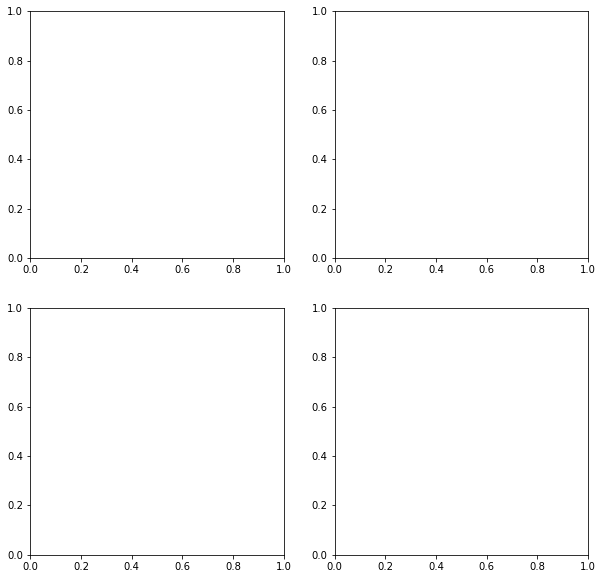

In [32]:
normalized_cell_centers = np.array([c / height for c in cell_centers])
font = {'size' : 10}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(2, 2, figsize=(12,12))

for i in range(n_iterations):
  axs[0, 0].plot(normalized_cell_centers, q_iterations[i], label = 'iteration {:2n}'.format(i))
  axs[0, 0].set_ylabel('$q$ (W)')

  axs[0, 1].plot(normalized_cell_centers, solid_temp_iterations[i], label = 'iteration {:2n}'.format(i))
  axs[0, 1].set_ylabel('$T_s$ (K)')

  axs[1, 0].plot(normalized_cell_centers, fluid_temp_iterations[i], label = 'iteration {:2n}'.format(i))
  axs[1, 0].set_ylabel('$T_f$ (K)')

  axs[1, 1].plot(normalized_cell_centers, fluid_density_iterations[i], label = 'iteration {:2n}'.format(i))
  axs[1, 1].set_ylabel('$\\rho_f$ (g/cm$^3$)')

for ax in axs.flat:
  ax.set(xlabel = 'Normalized Axial Coordinate')
  ticks = np.arange(H / height / 2.0, 1.0, H / height)
  ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
  ax.set_xticks(ticks, minor = True)
  ax.legend()
  ax.grid()